# Part 1 ‑ Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15-minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns

In [2]:
data = pd.read_json('/Users/majapedigo/Downloads/ultimate_challenge/logins.json')
data.describe()

/var/folders/cm/9dfbj1d120jdng2k7fghmx0r0000gn/T/ipykernel_6369/1273202833.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data.describe()


,login_time
count,93142
unique,92265
top,1970-03-17 01:01:39
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [3]:
df = data

In [4]:
# resample data on login time, using the number of logins per 15 min. 
df = df.resample('15T', on='login_time').count()

# rename count column (note: login time is now index)
df.rename(columns={'login_time': 'login_count'}, inplace=True)
df.reset_index(inplace=True)
df.head()


,login_time,login_count
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


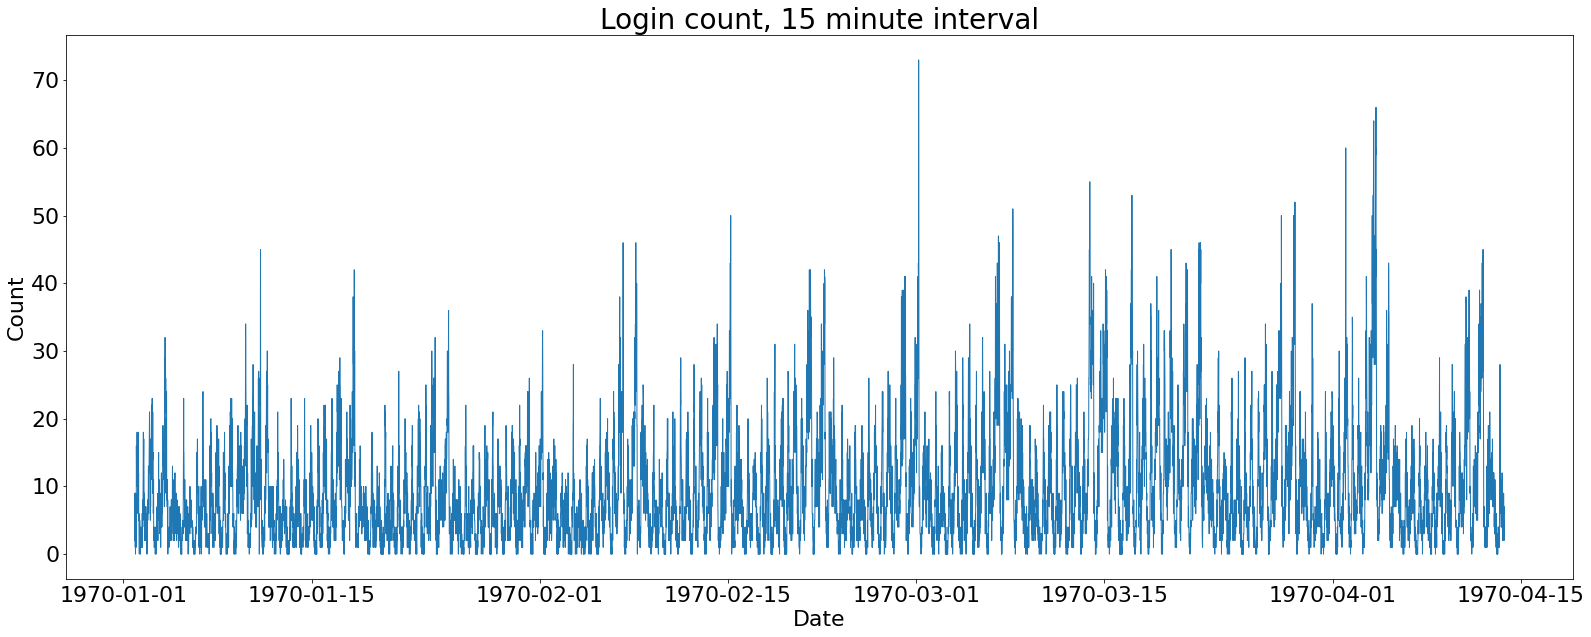

In [5]:
fig, ax = plt.subplots(figsize=(27, 10))
ax.plot(df['login_time'], df['login_count'], linewidth=1)
ax.tick_params(labelsize=22)
ax.set_title('Login count, 15 minute interval', fontsize=28)
ax.set_xlabel('Date', fontsize=22)
ax.set_ylabel('Count', fontsize=22)
plt.show()

Overall, we can observe periodicity on a weekly basis. There also seems to be a slight upward trend. To explore further, we will plot daily and hourly login count. 

In [6]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
week_data = df.groupby(df['login_time'].dt.day_name()).sum().reindex(days)

day_data = df.groupby(df['login_time'].dt.hour).sum()
day_data.index = pd.to_datetime(day_data.index, unit='h').strftime("%I:%M %p")

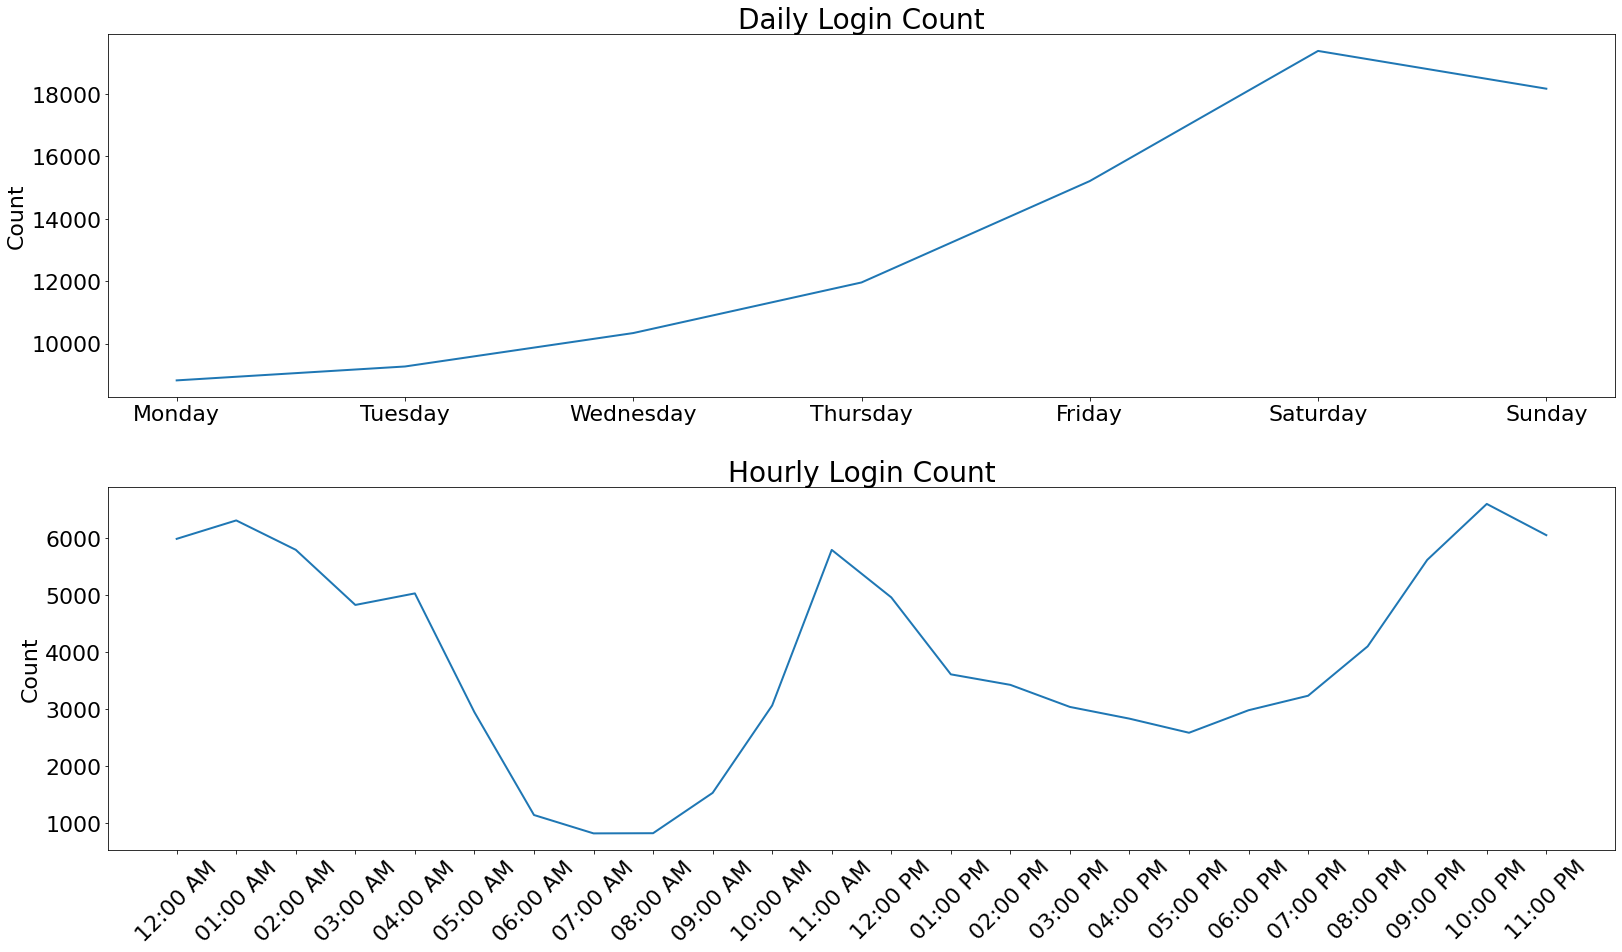

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(27, 15))

fig.subplots_adjust( 
    hspace=0.25
)

plt.xticks(rotation=45)

ax[0].plot(week_data.index, week_data['login_count'], linewidth=2)
ax[0].tick_params(labelsize=22)
ax[0].set_title('Daily Login Count', fontsize=28)
ax[0].set_ylabel('Count', fontsize=22)

ax[1].plot(day_data.index, day_data['login_count'], linewidth=2)
ax[1].tick_params(labelsize=22)
ax[1].set_title('Hourly Login Count', fontsize=28)
ax[1].set_ylabel('Count', fontsize=22)

plt.show()

In [8]:
# convert RangeIndex to DateTimeIndex to be able to use .resample()
df['login_time'] = pd.to_datetime(df['login_time'])
df = df.set_index('login_time')
logins_daily = df.resample('D').sum()
logins_daily

,login_count
login_time,
1970-01-01,112
1970-01-02,681
1970-01-03,793
1970-01-04,788
1970-01-05,459
...,...
1970-04-09,818
1970-04-10,1009
1970-04-11,1352


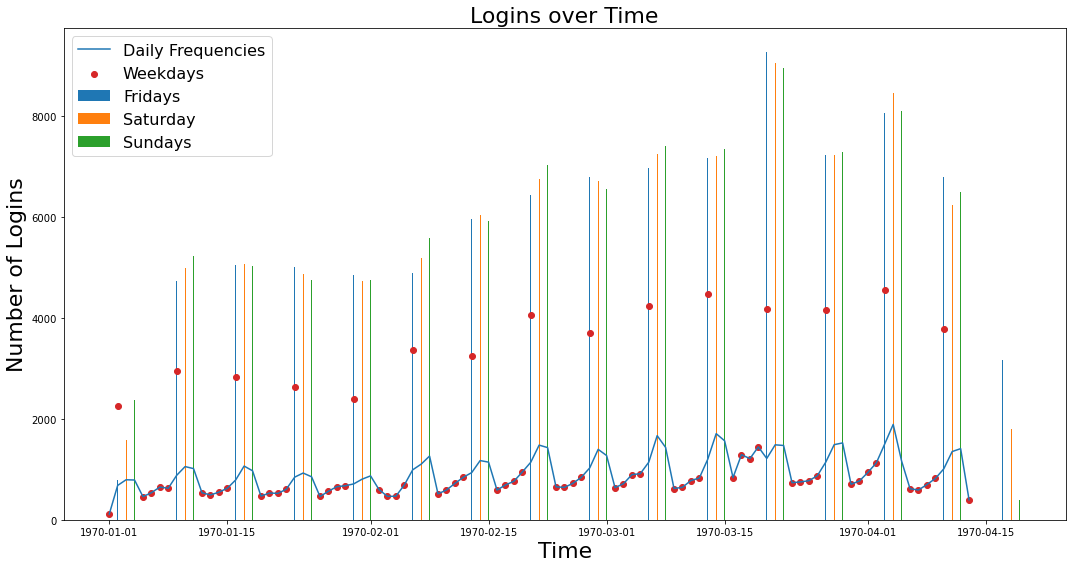

In [9]:
logins_daily = df.resample('D').sum()
logins_biz_day = df.resample('B').sum()
fridays = df.resample('W-FRI').sum()
saturdays = df.resample('W-SAT').sum()
sundays = df.resample('W-SUN').sum()


# line, scatterplot, and histograms of the binned data
fig, ax = plt.subplots(figsize = (15,8))
plt.xlabel('Time', fontsize = 22)
plt.ylabel('Number of Logins', fontsize = 22)
plt.title('Logins over Time', fontsize = 22)

plt.bar(fridays.index, fridays.login_count, align= 'center', width = 0.1, label = "Fridays")
plt.bar(saturdays.index, saturdays.login_count, label = 'Saturday', align = 'center', width = 0.1)
plt.bar(sundays.index, sundays.login_count, label = "Sundays", align= 'center', width = 0.1)
plt.plot(logins_daily.index, logins_daily.login_count, label = 'Daily Frequencies')
plt.scatter(logins_biz_day.index, logins_biz_day.login_count, label='Weekdays')

plt.legend(loc='upper left', fontsize = 16)
plt.tight_layout()

###### Summary:

Weekly, weekends have the most activity - Saturday is the peak. 
On a daily level, activity is low during the night and in the morning, peaks between 10:30 am and 12:00 pm, falls down again until after 8:00 pm, with the highest peak at 10:00 pm.

# Part 2 ‑ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?</i>

##### Answer:

Managers should monitor reimbursment costs, compared to the revenue of the tolls before the experiment period as KPI, as increase in revenue would mean heavier usage of tolls. 

2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
    
    a) how you will implement the experiment

    b) what statistical test(s) you will conduct to verify the significance of the observation

    c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.

a) Implementation

Capture data on:

- Tolls incurred 
- Revenue generated with tolls
- The experiment would last 1 month as that should be end of a business cycle.

Null Hypothesis

The mean amount of drivers crossing the bridge after reimbursing toll costs remains the same or is less.

Alternate Hypothesis

The mean amount of drivers crossing the bridge after reimbursing toll costs increases.


b) a two sample t-Test to compare the mean daytime bridge crossing into Metropolis of the most recent 4 weeks to the 4 weeks following reimbursement implementation. *If we have a complete historical record of bridge crossings (i.e. we know the population variance) we could use a Z-test.

c) If the p-value is less than 0.05 then we can reject the null hypothesis and recommend the reimbursement program. If the p-value is greater than 0.05 then we would fail to reject the null hypothesis, and therefor recommend a different approach.

# Part 3 ‐ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.

In [10]:
user_data = pd.read_json('/Users/majapedigo/Downloads/ultimate_challenge/ultimate_data_challenge.json')


In [11]:
user_data.head()


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [12]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


We have a mix of categorical and numerical values. We need to convert signup_date and last_trip_date to datetime objects.

In [13]:
user_data['signup_date'] = pd.to_datetime(user_data['signup_date'])
user_data['last_trip_date'] = pd.to_datetime(user_data['last_trip_date'])

avg_rating_of_driver, phone, and avg_rating_by_driver are partly null, but it seems like those are just instances of users / drivers not entering information. It could be by choice or circumstance, but right now it seems inconsequential.



In [14]:
# Create a new column denoting whether a user is active or not
user_data['active_user'] = user_data['trips_in_first_30_days'] > 0
user_data['active_user'] = user_data['active_user'].astype(int)

In [15]:
from datetime import timedelta

# Create a column which represents whether a user's last trip happened 5 months (5 x 30 days) after their signup date

user_data['active_6month'] = user_data.last_trip_date > (user_data.signup_date + timedelta(days=5*30))
user_data['active_6month'] = user_data['active_6month'].astype(int)


# How many users are active in their 6th month, or greater, from their signup date?
user_data.active_6month.sum()

12198

In [16]:
# Convert ultimate_black_user to int
user_data['ultimate_black_user'] = user_data.ultimate_black_user.astype(int)

In [17]:
# Show the number of unique values per feature
data.nunique()

login_time    92265
dtype: int64

In [18]:
# Statistically describe each numeric column in the data
user_data.describe(datetime_is_numeric=True)

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_user,active_6month
count,50000.000000,50000,41878.000000,50000.000000,50000,50000.000000,50000.00000,50000.000000,50000.000000,49799.000000,50000.000000,50000.000000
mean,2.278200,2014-01-16 13:04:20.352000,4.601559,1.074764,2014-04-19 08:02:04.992000256,8.849536,0.37708,60.926084,5.796827,4.778158,0.692200,0.243960
min,0.000000,2014-01-01 00:00:00,1.000000,1.000000,2014-01-01 00:00:00,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,2014-01-09 00:00:00,4.300000,1.000000,2014-02-14 00:00:00,0.000000,0.00000,33.300000,2.420000,4.700000,0.000000,0.000000
50%,1.000000,2014-01-17 00:00:00,4.900000,1.000000,2014-05-08 00:00:00,0.000000,0.00000,66.700000,3.880000,5.000000,1.000000,0.000000
75%,3.000000,2014-01-24 00:00:00,5.000000,1.050000,2014-06-18 00:00:00,8.600000,1.00000,100.000000,6.940000,5.000000,1.000000,0.000000
max,125.000000,2014-01-31 00:00:00,5.000000,8.000000,2014-07-01 00:00:00,100.000000,1.00000,100.000000,160.960000,5.000000,1.000000,1.000000
std,3.792684,NaN,0.617338,0.222336,NaN,19.958811,0.48466,37.081503,5.707357,0.446652,0.461588,0.429473


In [19]:
# How many users are and aren't active users?
user_data.active_user.value_counts()

1    34610
0    15390
Name: active_user, dtype: int64

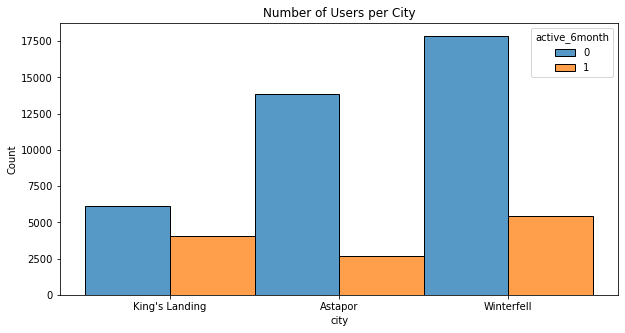

In [20]:
plt.figure(figsize=(10,5))
sns.histplot(data=user_data, x='city', hue='active_6month', multiple='dodge')
plt.title('Number of Users per City');

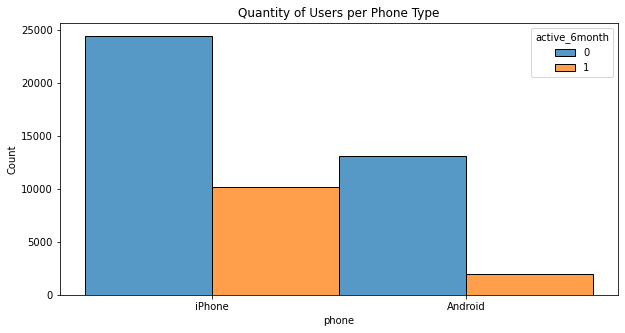

In [21]:
plt.figure(figsize=(10,5))
sns.histplot(data=user_data, x='phone', hue='active_6month', multiple='dodge')
plt.title('Quantity of Users per Phone Type');

Retained users more often have iPhones than non-retained users

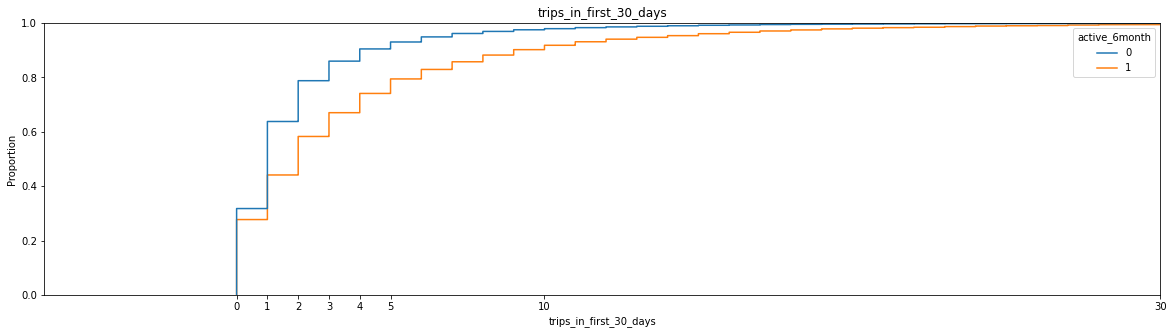

In [22]:
plt.figure(figsize=(20,5))
sns.ecdfplot(data=user_data, x='trips_in_first_30_days', hue='active_6month')
plt.xticks(ticks=[0,1,2,3,4,5,10,30])
plt.xlim(right=30)
plt.title('trips_in_first_30_days');

Retained users took more trips in their first 30 days than non-retained users did

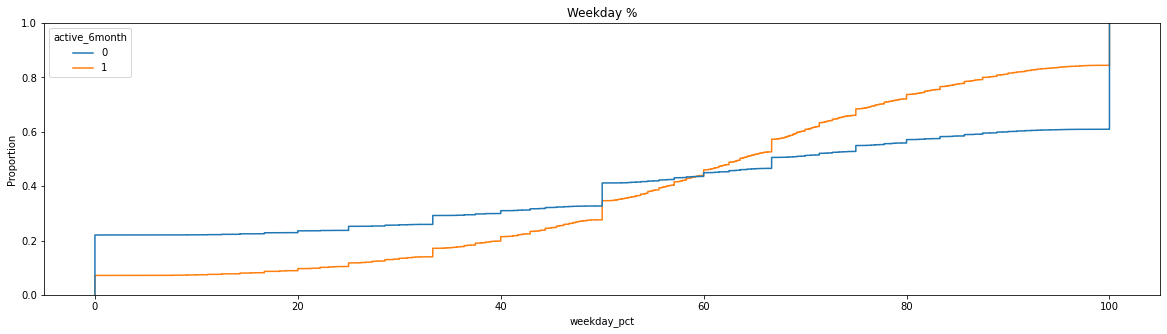

In [23]:
plt.figure(figsize=(20,5))
sns.ecdfplot(data=user_data, x='weekday_pct', hue='active_6month')
plt.title('Weekday %');

Retained users had higher percentage of total rides being on weekdays

In [24]:
# Convert categorical columns to numerical, for ML
data = pd.get_dummies(user_data)

In [25]:
def gen_corr_to_target(dataframe, target, title=None, annot=False, save=None):
    '''
    'Generate a correlation heatmap between the target feature and other features.'
    
    Args:
        dataframe (Pandas DataFrame): Contains relevant data
        target (string): Column name, which is within the passed DataFrame, that's to be targeted
        title (string): If passed, then adds title via matplotlib plt.title
        annot (boolean): If True, then annotates values per square on matrix heatmap
        save (boolean): If True, then uses save_and_show_plot function to save plot as a .png, then displays plot
        
    Returns:
        None. Displays the produced plot.
    '''
    plt.figure(figsize=(4, 6))
    sns.set(font_scale=1)

    sns.heatmap(dataframe.corr()[[target]].sort_values(target, ascending=False)[1:], vmin=-1, vmax=1,
                center=0, annot=annot, cmap='bwr')

    if title:
        plt.title(f'\n{title}\n', fontsize=18)
        
    if save:
        filepath = title + '.png'
        save_and_show_plot(filepath)


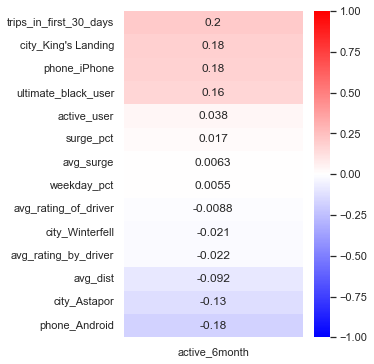

In [26]:
# Generate a heatmap that shows the correlation between all features against active_6month
gen_corr_to_target(data, 'active_6month', annot=True)

In [27]:
# Fill the columns with null values with the average value of their columns
data.avg_rating_of_driver.fillna(data.avg_rating_of_driver.mean(), inplace=True)
data.avg_rating_by_driver.fillna(data.avg_rating_by_driver.mean(), inplace=True)

In [28]:
# I kept getting an error because I needed to convert datetime object to numeric earlier. I will do so now.

# Convert signup_date
data['signup_date'] = data['signup_date'].dt.strftime("%Y%m%d").astype(int)
# Convert last_trip_date
data['last_trip_date'] = data['last_trip_date'].dt.strftime("%Y%m%d").astype(int)

In [29]:
from sklearn.model_selection import train_test_split


In [30]:
# Remove unhelpful features from data
model_data = data.drop(columns='last_trip_date')

# Separate the target variable (active_user, y) from the predictor variables (X)
X = model_data.drop('active_6month', axis=1)
y = model_data['active_6month']

# Randomly separate the data into training and testing sets
# Defined randomness for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [31]:
# Import relevant packages
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [32]:
# Create a dictionary to save model names, their performance, and the time it took to train it
model_performance_dict = {}


In [33]:
def runModel_savePerformance(model_name, model):
    """Fit the model to training data, score each fold with a given metric, then add elapsed-time and
    the performance scores to the given dictionary."""
    
    # Import cross validation function
    from sklearn.model_selection import cross_validate
    
    # Save the results of 5 fold cross validation over the training data with the given model
    cv = cross_validate(model, X_train, y_train, cv=5, scoring=['accuracy','f1','precision','recall'])
    
    # Save averaged model performance metrics
    model_performance_dict[model_name] = {'Fit Time (s)':np.mean(cv['fit_time']), 'Accuracy':np.mean(cv['test_accuracy']), 'f1':round(np.mean(cv['test_f1']), 4), 'Precision':np.mean(cv['test_precision']), 'Recall':np.mean(cv['test_recall'])}

#### Logistic Regression


In [34]:
import warnings
warnings.filterwarnings("ignore")


model = LogisticRegression(random_state=0, max_iter=1000)

runModel_savePerformance('Logistic Regression', model)

#### Decision Tree Classification



In [35]:
model = DecisionTreeClassifier()

runModel_savePerformance('Tree', model)

#### KNN Classification


In [36]:
model = KNeighborsClassifier()

runModel_savePerformance('KNN', model)

#### Random Forest Classification


In [37]:
model = RandomForestClassifier(random_state=0)

runModel_savePerformance('Random Forest', model)

#### AdaBoost Classification

In [38]:
model = AdaBoostClassifier(random_state=0)

runModel_savePerformance('AdaBoost', model)

In [39]:
# Convert the saved model performances from a dictionary to a DataFrame with the model names as indexes
model_performance_df = pd.DataFrame(model_performance_dict).T

# Sort the values by Accuracy DESC then Runtime ASC
model_performance_df = model_performance_df.sort_values(by=['f1','Fit Time (s)'], ascending=[False, True])

# Style the DataFrame to appropriately highlight the best value per metric
model_performance_df_styled = model_performance_df.style.highlight_max(subset=['f1','Accuracy','Precision','Recall'], color='#b5ff9e', axis=0).highlight_min(subset='Fit Time (s)', color='#b5ff9e', axis=0)

# Style the DataFrame to only show 4 floating points
model_performance_df_styled = model_performance_df_styled.format('{:.4f}')

In [40]:
# Show the sorted model performances DataFrame
model_performance_df_styled

,Fit Time (s),Accuracy,f1,Precision,Recall
AdaBoost,0.6849,0.8202,0.5747,0.6816,0.4969
Random Forest,2.1014,0.8114,0.5557,0.6553,0.4825
KNN,0.0329,0.7838,0.5012,0.5750,0.4443
Tree,0.1097,0.7489,0.4943,0.4870,0.5019
Logistic Regression,0.0335,0.7554,0.0000,0.0000,0.0000


#### Final Model
Of the untuned models AdaBoost performed the best overall. However, Ultimate is interested in how to leverage the insights from the model to improve long term rider retention.

With this in mind, a decision tree with "shallow" depth is more interpretable. Furthermore, Adaboost's accuracy was 82% and Decision Tree's was 75%, each essentially choosing 3/4 correct; both were essentially 3/4 correct.

I'll be moving forward with Decision Tree as the final model, and I'll tune its hyperparameters for improved performance and interpretability.

In [41]:
from sklearn.model_selection import GridSearchCV


In [42]:
# Create a Decision Tree model, a distribution of hyperparameters to search over for best perforamnce, and a Grid Search Cross-Validator object.
tree = DecisionTreeClassifier(random_state=0)
param_grid = {'max_depth':[2,3,4],'criterion':['gini','entropy']}
GSCV = GridSearchCV(tree, param_grid=param_grid, n_jobs=3, cv=4, scoring=['accuracy','recall','precision'], refit='accuracy')

In [43]:
# Fit the Grid Search Cross-Validator to the training data
GSCV.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0), n_jobs=3,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4]},
             refit='accuracy', scoring=['accuracy', 'recall', 'precision'])

In [44]:
GSCV.best_score_

0.7913066666666667

In [45]:
GSCV.best_params_

{'criterion': 'gini', 'max_depth': 4}

In [46]:
# Train the final tree with the best found parameters
final_model = DecisionTreeClassifier(**GSCV.best_params_)

In [47]:
# Fit the model to the training data
final_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

In [48]:
# Predict the target variable with the holdout test data
y_pred = final_model.predict(X_test)

In [49]:
# Calculate the accuracy score of the final model against holdout test data
final_model.score(X_test, y_test)

0.79408

In [50]:
from sklearn.metrics import classification_report

In [51]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      9473
           1       0.62      0.39      0.48      3027

    accuracy                           0.79     12500
   macro avg       0.72      0.66      0.68     12500
weighted avg       0.78      0.79      0.78     12500



In [52]:
import graphviz
from sklearn.tree import export_graphviz

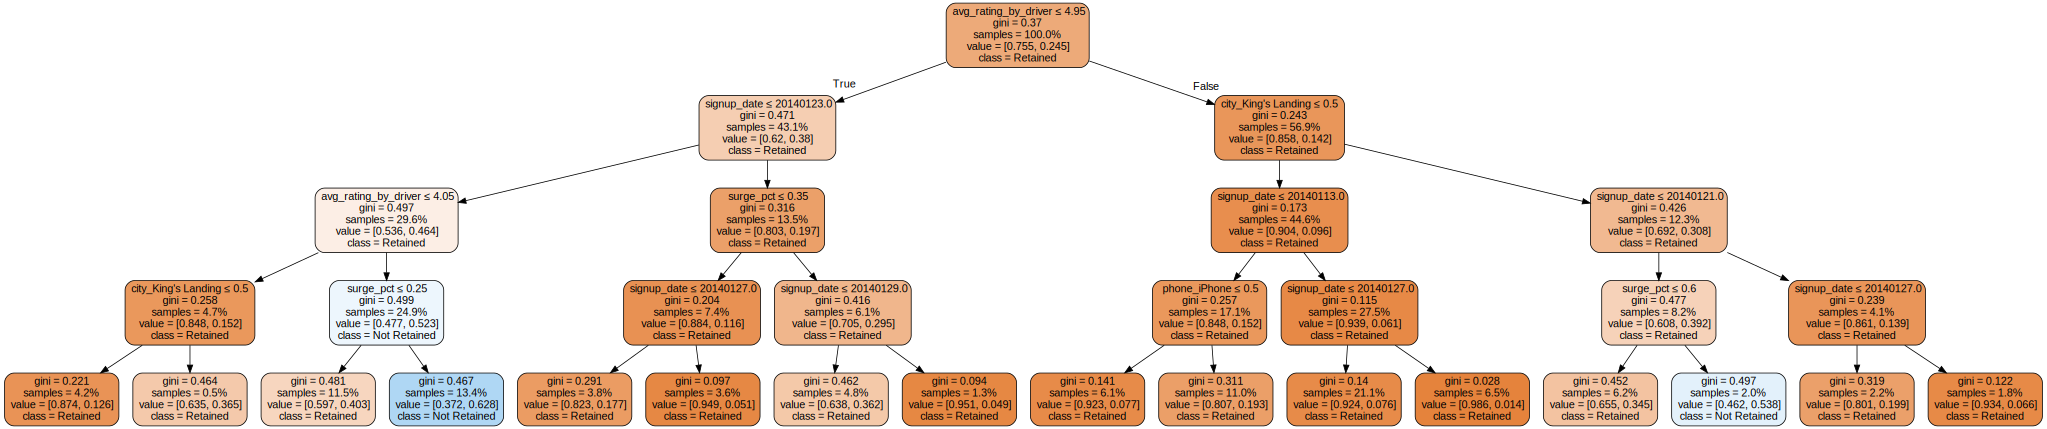

In [53]:
dot_data = export_graphviz(final_model, feature_names=X_train.columns, class_names=['Retained','Not Retained'], proportion=True, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data) 
graph

The final model chosen was decision tree classification, achieved an accuracy of 79%.

**What fraction of the observed users were retained?**

In [54]:
print(f'{data.active_user.sum()} of {len(data)} users were retained.\n\nThis was calculated by summing the amount of users who took more than 0 trips in the preceding 30 days after their signup date.')

34610 of 50000 users were retained.

This was calculated by summing the amount of users who took more than 0 trips in the preceding 30 days after their signup date.
